In [ ]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.cluster import KMeans, MiniBatchKMeans

# Load the data and group it by unique keys for visualization

In [181]:
MAX_POS=12

df_put = pd.read_table("loops_13.putative_cdr.txt", sep="\t")
df_cdr = pd.read_table("loops_13.real_cdr.txt", sep="\t")

for key in set(df_put["pdb_id_kmer"]).intersection(df_cdr["pdb_id"]):
    df_put = df_put.loc[df_put["pdb_id_kmer"] != key,:]

In [182]:
print(df_put.columns)
df_put.columns = ["pdb_id", "chain", "start", "length", "pos", "aa", "x", "y", "z", "rmsd"]
print(df_put.isnull().values.any())
df_put["chain"] = df_put["chain"] + "_" + df_put["start"].astype('str')
print(df_put.isnull().values.any())
df_put.drop(["start"], inplace=True, axis=1)
df_put.head()

Index([u'pdb_id_kmer', u'chain_id_kmer', u'start_kmer', u'len_tcr', u'pos_tcr',
       u'aa_kmer', u'x_kmer', u'y_kmer', u'z_kmer', u'rmsd'],
      dtype='object')
False
False


,pdb_id,chain,length,pos,aa,x,y,z,rmsd
0,12ca,A_72,13,0,A,0.000000,0.000000,0.000000,1.471901
1,12ca,A_72,13,1,V,2.435867,0.419666,2.914133,1.471901
2,12ca,A_72,13,2,L,3.901272,-1.472012,5.806936,1.471901
3,12ca,A_72,13,3,K,5.112862,0.373801,8.957265,1.471901
4,12ca,A_72,13,4,G,5.346375,-0.093429,12.738140,1.471901


In [183]:
print(df_cdr.columns)
df_cdr.columns = ["pdb_id", "chain", "length", "pos", "aa", "x", "y", "z"]
df_cdr.head()

Index([u'pdb_id', u'tcr_chain', u'len_tcr', u'pos_tcr', u'aa_tcr', u'x', u'y',
       u'z'],
      dtype='object')


,pdb_id,chain,length,pos,aa,x,y,z
0,2iam,TRA,13,0,C,0.000000,0.000000,0.000000
1,2iam,TRA,13,1,A,2.509573,1.112225,2.513987
2,2iam,TRA,13,2,A,3.364967,-0.345859,5.977036
3,2iam,TRA,13,3,L,5.778524,0.067249,8.943966
4,2iam,TRA,13,4,I,8.380416,-2.555646,9.870885


In [184]:
print(df_put.isnull().values.any())
print(df_cdr.isnull().values.any())

False
False


In [185]:
tmp1 = df_put.loc[(df_put["pos"] == 0) & (df_put["aa"] == "C"), ["pdb_id", "chain"]]
tmp2 = df_put.loc[((df_put["pos"] == MAX_POS) & (df_put["aa"] == "F")) | 
                  (((df_put["pos"] == MAX_POS) & (df_put["aa"] == "W"))), 
                  ["pdb_id", "chain"]]
tmp3 = set(tmp1["pdb_id"] + "_" + tmp1["chain"]).intersection(set(tmp2["pdb_id"] + "_" + tmp2["chain"]))
tmp4 = list(df_put["pdb_id"] + "_" + df_put["chain"])

df_can = df_put.copy()
indices = []
for key in sorted(tmp3):
    indices.extend(range(tmp4.index(key), tmp4.index(key)+13))

df_can = df_can.iloc[indices, :]
# print(df_put.shape)
# df_put = df_put.iloc[indices, :]
# print(df_put.shape)
# print(df_can.shape)
df_can.head()

,pdb_id,chain,length,pos,aa,x,y,z,rmsd
819,1a3r,H_94,13,0,C,0.000000,0.000000,0.000000,1.289135
820,1a3r,H_94,13,1,D,2.328698,1.425267,2.660179,1.289135
821,1a3r,H_94,13,2,G,3.429601,-0.679190,5.622885,1.289135
822,1a3r,H_94,13,3,Y,5.486569,0.740824,8.490734,1.289135
823,1a3r,H_94,13,4,Y,7.316678,-1.735490,10.741675,1.289135


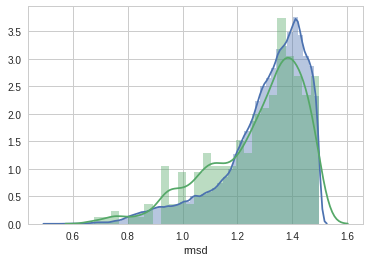

In [186]:
sns.distplot(df_put["rmsd"])
sns.distplot(df_can["rmsd"])

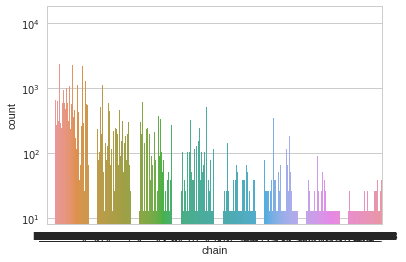

In [187]:
sns.countplot(df_put["chain"], log="y")

In [188]:
df_cdr.head()

,pdb_id,chain,length,pos,aa,x,y,z
0,2iam,TRA,13,0,C,0.000000,0.000000,0.000000
1,2iam,TRA,13,1,A,2.509573,1.112225,2.513987
2,2iam,TRA,13,2,A,3.364967,-0.345859,5.977036
3,2iam,TRA,13,3,L,5.778524,0.067249,8.943966
4,2iam,TRA,13,4,I,8.380416,-2.555646,9.870885


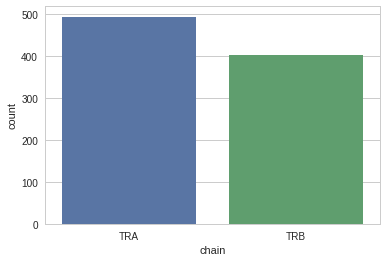

In [189]:
sns.countplot(df_cdr["chain"])

In [190]:
def save_df(df_inp, coord, filename):
    df = df_inp.pivot_table(coord, ["pdb_id", "chain"], columns="pos")
    df = df.reset_index()

    df2 = df_inp.pivot_table("aa", ["pdb_id", "chain"], aggfunc=sum)
    df2 = df2.reset_index()

    df["sequence"] = df2["aa"]
    df["key"] = df["pdb_id"] + "_" + df["chain"]
    df.drop(["pdb_id", "chain"], axis=1, inplace=True)
    df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
    df.to_csv(filename, compression="gzip")
    print(df.shape)
    print(df.head())
    

save_df(df_put, "x", "put_coord_x.csv.gz")
save_df(df_put, "y", "put_coord_y.csv.gz")
save_df(df_put, "z", "put_coord_z.csv.gz")

save_df(df_can, "x", "can_coord_x.csv.gz")
save_df(df_can, "y", "can_coord_y.csv.gz")
save_df(df_can, "z", "can_coord_z.csv.gz")

save_df(df_cdr, "x", "cdr_coord_x.csv.gz")
save_df(df_cdr, "y", "cdr_coord_y.csv.gz")
save_df(df_cdr, "z", "cdr_coord_z.csv.gz")

(74528, 15)
pos         key       sequence    0         1         2         3         4  \
0     12ca_A_72  AVLKGGPLDGTYR  0.0  2.435867  3.901272  5.112862  5.346375   
1     12e8_H_47  IGWIDPEIGDTEY  0.0  2.608043  3.500156  5.651162  7.197959   
2    12e8_M_193  CEATHKTSTSPIV  0.0  2.559624  3.279936  5.192563  6.338426   
3     12e8_P_47  IGWIDPEIGDTEY  0.0  2.531457  3.458591  5.535513  7.100307   
4     132l_A_48  GSTDYGILQINSR  0.0  3.120708  3.342358  5.694073  7.152789   

pos         5          6          7          8          9        10        11  \
0    6.424403  10.237835  10.422076  11.773136  10.111284  7.667701  7.872698   
1    6.547158   9.224579  12.119193  10.590880  11.240486  8.724633  7.982416   
2    9.012737  11.169627  12.315048  12.539943  11.822830  8.221191  7.537343   
3    6.451582   8.845555  11.884481  10.683487  11.162031  8.671444  7.938718   
4    8.495722  10.194527  11.626809   8.675602  10.739508  8.774272  8.025248   

pos        12  
0    6.054

In [193]:
df_put_x = pd.melt(df_put, ["pdb_id", "chain", "pos"], "x")
df_put_y = pd.melt(df_put, ["pdb_id", "chain", "pos"], "y")
df_put_z = pd.melt(df_put, ["pdb_id", "chain", "pos"], "z")

df_can_x = pd.melt(df_can, ["pdb_id", "chain", "pos"], "x")
df_can_y = pd.melt(df_can, ["pdb_id", "chain", "pos"], "y")
df_can_z = pd.melt(df_can, ["pdb_id", "chain", "pos"], "z")

df_cdr_x = pd.melt(df_cdr, ["pdb_id", "chain", "pos"], "x")
df_cdr_y = pd.melt(df_cdr, ["pdb_id", "chain", "pos"], "y")
df_cdr_z = pd.melt(df_cdr, ["pdb_id", "chain", "pos"], "z")

# Visualization

74528
281
69


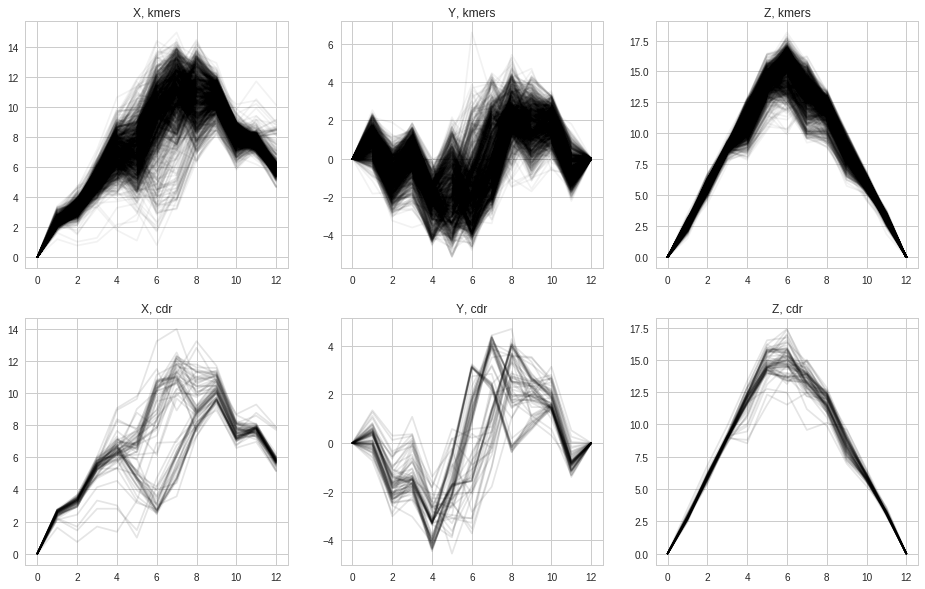

In [194]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
ax[0,0].set_title("X, kmers")
ax[0,1].set_title("Y, kmers")
ax[0,2].set_title("Z, kmers")
ax[1,0].set_title("X, cdr")
ax[1,1].set_title("Y, cdr")
ax[1,2].set_title("Z, cdr")

df_tmp = df_put_x.groupby(["pdb_id", "chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_can_x.groupby(["pdb_id", "chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_can_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_can_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.1)

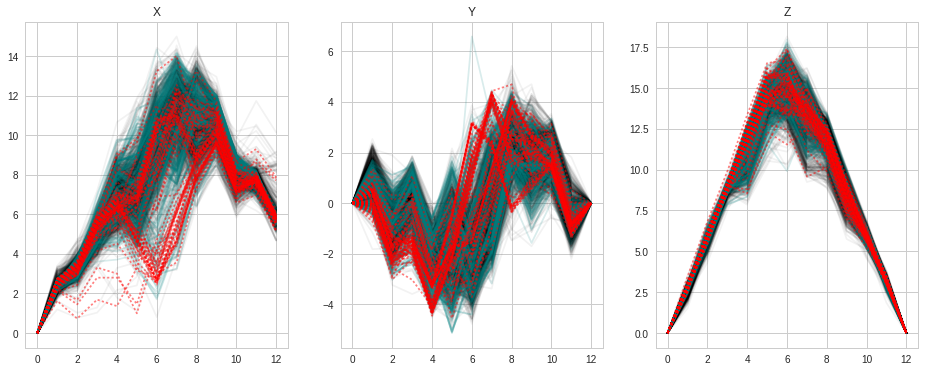

In [195]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")


df_tmp = df_put_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
        
df_tmp = df_can_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break

        
df_tmp = df_cdr_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)

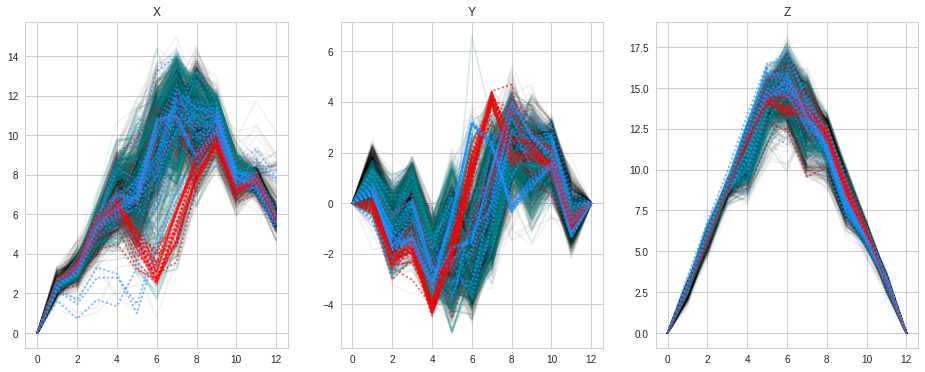

In [196]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
        
df_tmp = df_can_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
        
df_tmp = df_cdr_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)

## Summary
There is a clear distinction between TRA and TRB groups by the X-coordinate, with some anomalous CDRs.

TRB lines by the X-coordinate have very little neighbouring peptides in contrast to the TRA CDR chain sequences.

Real CDRs tend to have less deviation from the starting point and at the final point by the Y-coordinate.

Shape of lines for the Y-coordinate are pretty close for TRA and TRB.

# Distribution of coordinates per position

## X coordinate

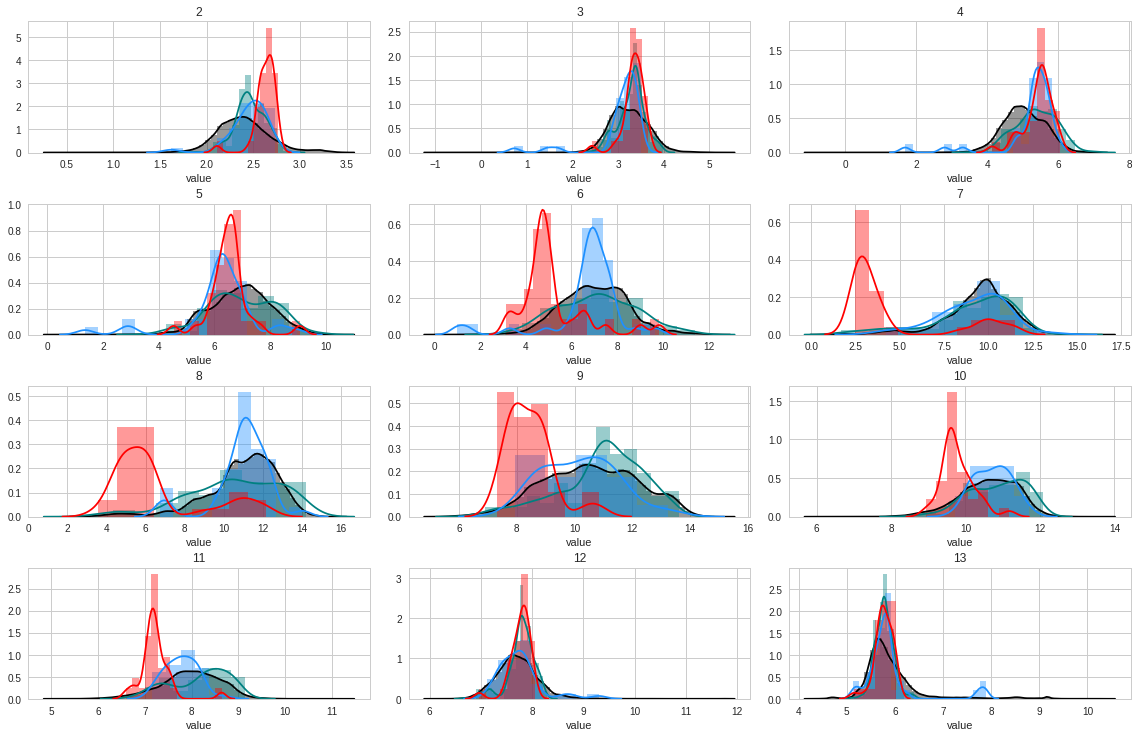

In [197]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,MAX_POS+1):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_x.loc[df_put_x["pos"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_can_x.loc[df_can_x["pos"] == j, "value"], ax=ax[r,c], color="teal")
    sns.distplot(df_cdr_x.loc[(df_cdr_x["pos"] == j) & (df_cdr_x["chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_x.loc[(df_cdr_x["pos"] == j) & (df_cdr_x["chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Y coordinate

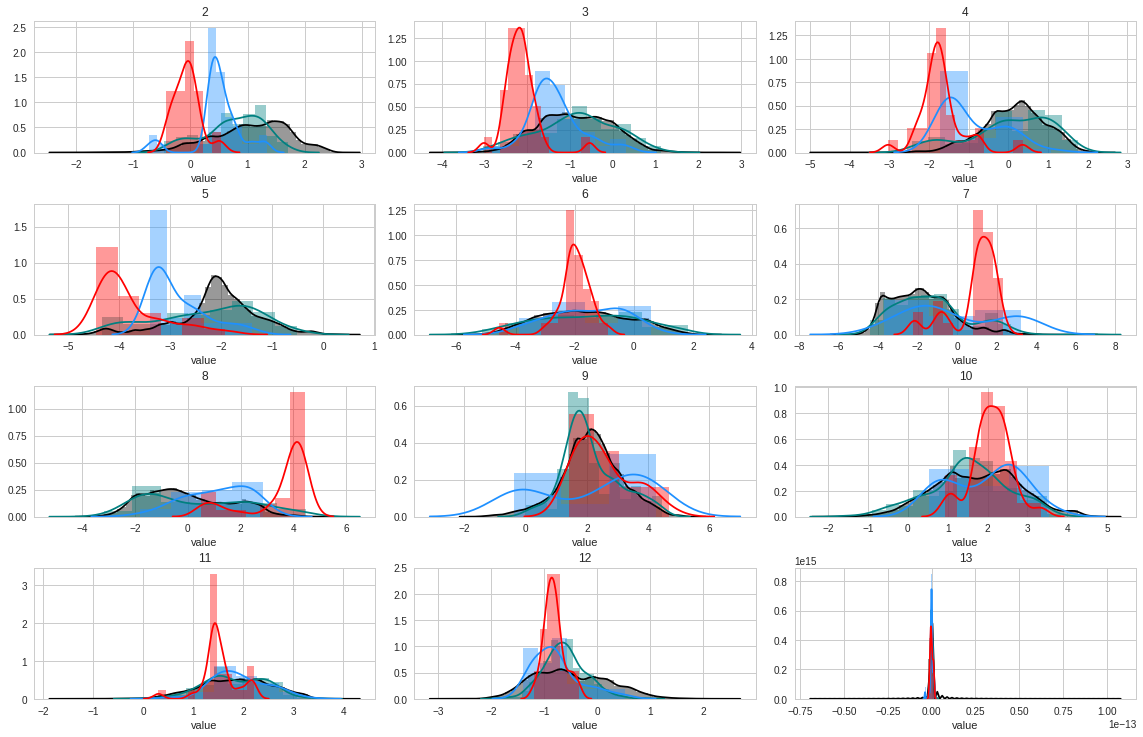

In [198]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,MAX_POS+1):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_y.loc[df_put_y["pos"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_can_y.loc[df_can_y["pos"] == j, "value"], ax=ax[r,c], color="teal")
    sns.distplot(df_cdr_y.loc[(df_cdr_y["pos"] == j) & (df_cdr_y["chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_y.loc[(df_cdr_y["pos"] == j) & (df_cdr_y["chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Z coordinate

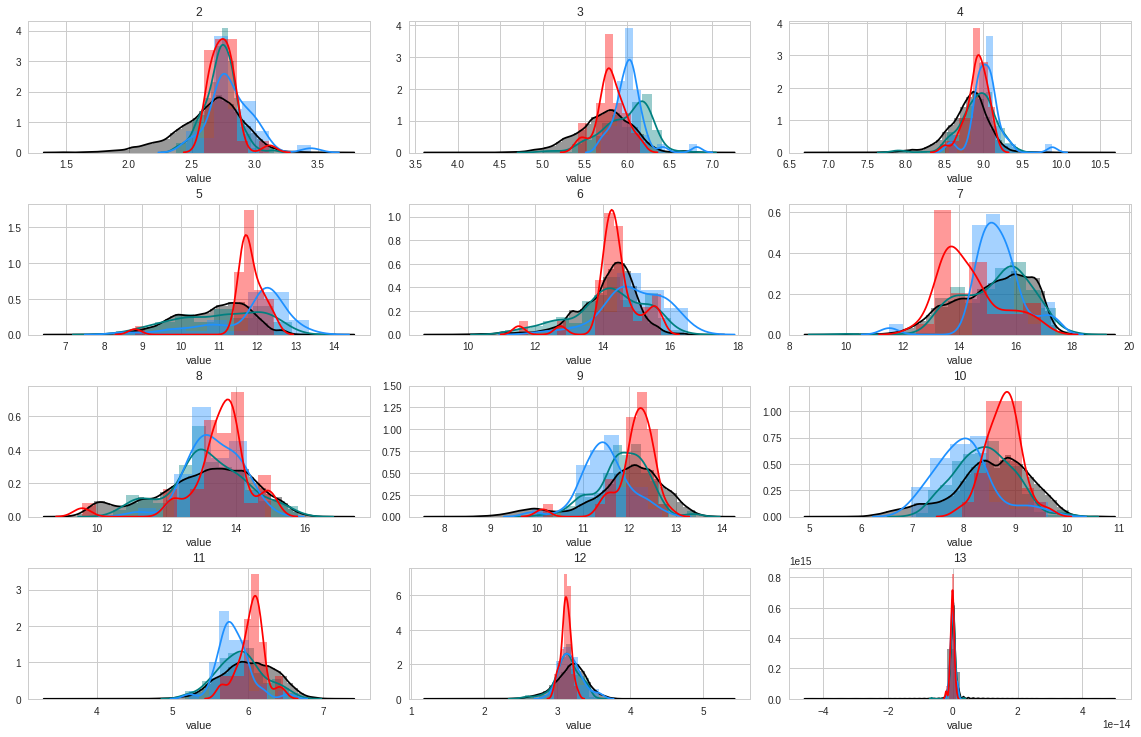

In [199]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,MAX_POS+1):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_z.loc[df_put_z["pos"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_can_z.loc[df_can_z["pos"] == j, "value"], ax=ax[r,c], color="teal")
    sns.distplot(df_cdr_z.loc[(df_cdr_z["pos"] == j) & (df_cdr_z["chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_z.loc[(df_cdr_z["pos"] == j) & (df_cdr_z["chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Summary

Distributions of coordinates for almost all positions for X and Z coodinates are close to Gauss.

Distributions of X coordinates for putative, TRA and TRB CDRs are quite close for the first 6 positions, and 12/13 positions.

TRA and putative distributions at the X coordinate are very close for all positions.

TRB is much lower than TRA/putative for the X coordinate at positions 6,7,8,9,10,11.

Distributions of Y coordinates for real CDRs are lower than for the putative ones in the first 5 positions. For 7 and 8 positions real CDRs are higher than the putative ones. This effect is more stronger for TRB than for TRA. (Probably due to Gly).

Distributions of Z coordinates are very similar to each other for all peptides.

# "Upside" / "downside" peptides analysis

In [200]:
df1 = df_cdr_x.loc[(df_cdr_x["pos"] == 2) & (df_cdr_x["value"] < 2) & (df_cdr_x["chain"] == "TRA"), :]
df2 = df_cdr_y.loc[(df_cdr_y["pos"] == 2) & (df_cdr_y["value"] < 0) & (df_cdr_y["chain"] == "TRA"), :]

df3 = df_cdr_x.loc[(df_cdr_x["pos"] == 6) & (df_cdr_x["value"] > 5) & (df_cdr_x["chain"] == "TRB"), :]
df4 = df_cdr_x.loc[(df_cdr_y["pos"] == 7) & (df_cdr_y["value"] < 3) & (df_cdr_y["chain"] == "TRB"), :]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(set(df1.pdb_id).intersection(set(df2.pdb_id)))
# print(df_cdr.loc[np.array(list(map(lambda x: x in set(df3.pdb_id).intersection(set(df4.pdb_id)), 
#                                    df_cdr_x["pdb_id"]))), :])

(3, 5)
(36, 5)
(7, 5)
(6, 5)
set(['3pqy', '4ozh', '4z7v'])


In [201]:
df1 = df_put_x.loc[(df_put_x["pos"] == 2) & (df_put_x["value"] < 2), :]
df2 = df_put_y.loc[(df_put_y["pos"] == 2) & (df_put_y["value"] < 0), :]

df3 = df_put_x.loc[(df_put_x["pos"] == 6) & (df_put_x["value"] > 5), :]
df4 = df_put_x.loc[(df_put_y["pos"] == 7) & (df_put_y["value"] < 3), :]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(276, 5)
(62376, 5)
(71766, 5)
(72423, 5)


In [202]:
df_cdr_x.loc[(df_cdr_x["pos"] == 6) & (df_cdr_x["value"] < 6) & (df_cdr_x["chain"] == "TRA"), :]

,pdb_id,chain,pos,variable,value
864,3pqy,TRA,6,x,4.706501
890,4z7v,TRA,6,x,4.205619


In [203]:
df_cdr_x.loc[(df_cdr_x["pos"] == 4) & (df_cdr_x["value"] < 4) & (df_cdr_x["chain"] == "TRA"), :]

,pdb_id,chain,pos,variable,value
524,4ozh,TRA,4,x,1.357835
862,3pqy,TRA,4,x,2.798550
888,4z7v,TRA,4,x,3.000207


In [204]:
df_cdr_x.loc[(df_cdr_x["pos"] == 6) & (df_cdr_x["value"] > 6) & (df_cdr_x["chain"] == "TRB"), :]

,pdb_id,chain,pos,variable,value
32,2xn9,TRB,6,x,11.144908
71,3vxr,TRB,6,x,9.548838
97,3vxs,TRB,6,x,9.711765
136,4y1a,TRB,6,x,10.337111
279,4y19,TRB,6,x,8.448482
331,3o4l,TRB,6,x,11.509035
877,1d9k,TRB,6,x,10.139364


# Correlations among coordinates

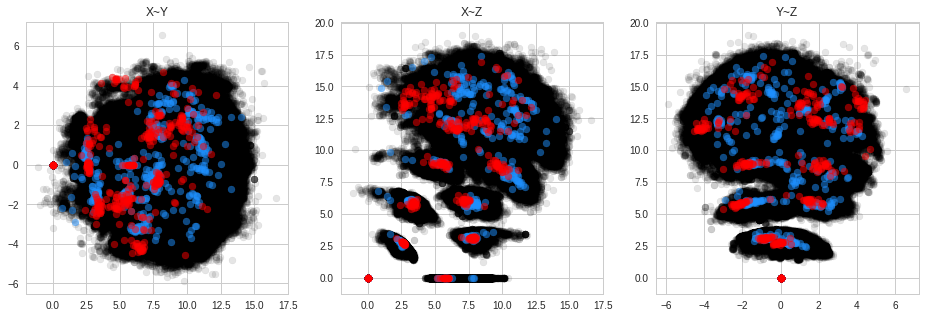

In [205]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(df_put_x["value"], df_put_y["value"], color="black", alpha=.1)
ax[0].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRA"), "value"], df_cdr_y.loc[(df_cdr_y["chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[0].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRB"), "value"], df_cdr_y.loc[(df_cdr_y["chain"] == "TRB"), "value"], color="red", alpha=.5)
ax[0].set_title("X~Y")

ax[1].scatter(df_put_x["value"], df_put_z["value"], color="black", alpha=.1)
ax[1].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRA"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[1].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRB"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRB"), "value"], color="red", alpha=.5)
ax[1].set_title("X~Z")

ax[2].scatter(df_put_y["value"], df_put_z["value"], color="black", alpha=.1)
ax[2].scatter(df_cdr_y.loc[(df_cdr_y["chain"] == "TRA"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[2].scatter(df_cdr_y.loc[(df_cdr_y["chain"] == "TRB"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRB"), "value"], color="red", alpha=.5)

ax[2].set_title("Y~Z")

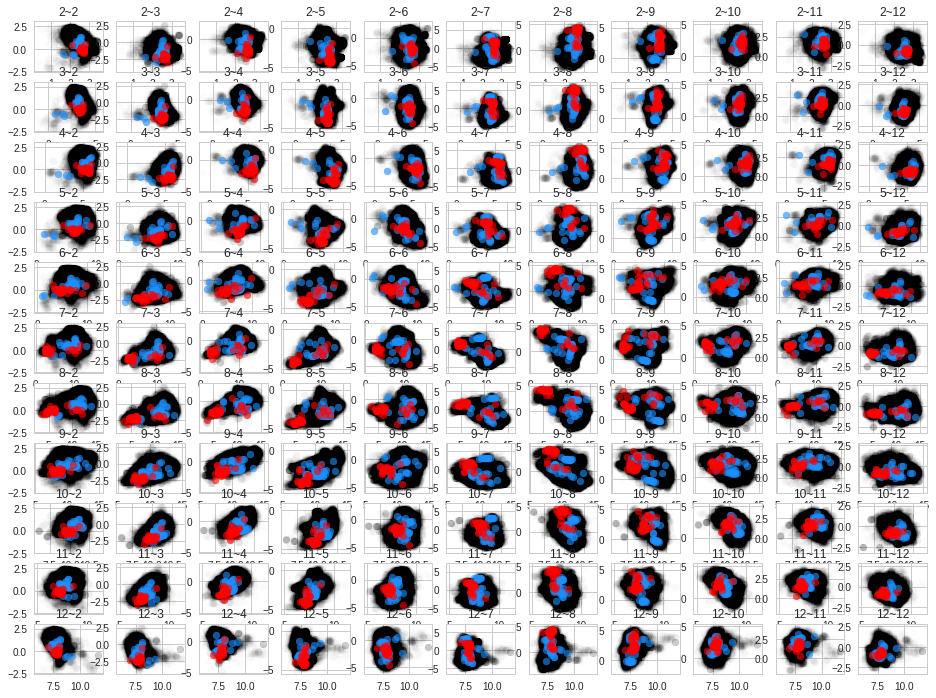

In [210]:
def plot_corr(df_put_l, df_put_r, df_cdr_l, df_cdr_r, pos_i, pos_j, ax):
    ax.scatter(df_put_l.loc[df_put_l["pos"] == pos_i, "value"], 
               df_put_r.loc[df_put_r["pos"] == pos_j, "value"], 
               color="black", alpha=.01)
    ax.scatter(df_cdr_l.loc[(df_cdr_l["pos"] == pos_i) & (df_cdr_l["chain"] == "TRA"), "value"], 
               df_cdr_r.loc[(df_cdr_r["pos"] == pos_j) & (df_cdr_r["chain"] == "TRA"), "value"], 
               color="dodgerblue", alpha=.6)
    ax.scatter(df_cdr_l.loc[(df_cdr_l["pos"] == pos_i) & (df_cdr_l["chain"] == "TRB"), "value"], 
               df_cdr_r.loc[(df_cdr_r["pos"] == pos_j) & (df_cdr_r["chain"] == "TRB"), "value"], 
               color="red", alpha=.6)
    ax.set_title(str(pos_i+1) + "~" + str(pos_j+1))


fig, ax = plt.subplots(MAX_POS-1, MAX_POS-1, figsize=(16,12))

# plt.tight_layout(h_pad=3)

for r in range(MAX_POS-1):
    for c in range(MAX_POS-1):
        plot_corr(df_put_x, df_put_y, df_cdr_x, df_cdr_y, r+1, c+1, ax[r,c])

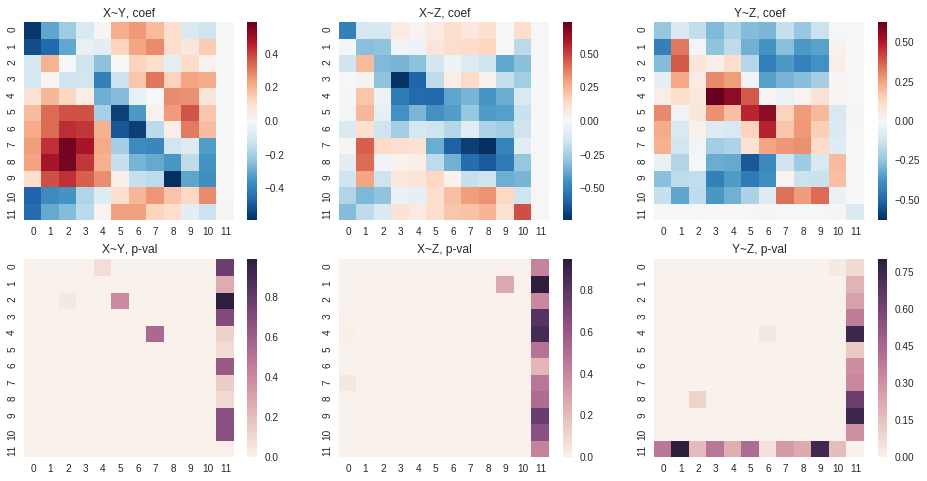

In [211]:
def plot_heatmap(df_x, df_y, df_z, fun):
    def compute(df1, df2):
        cors = np.zeros((MAX_POS,MAX_POS))
        pvals = np.zeros((MAX_POS,MAX_POS))
        for i in range(1,MAX_POS+1):
            for j in range(1,MAX_POS+1):
                val = stats.pearsonr(df1.loc[df1["pos"] == i, "value"], df2.loc[df2["pos"] == j, "value"])
                cors[i-1,j-1] = val[0]
                pvals[i-1,j-1] = val[1]
        return cors, pvals
    
    fig, ax = plt.subplots(2,3, figsize=(16,8))
    
    cors1, pvals1 = compute(df_x, df_y)
    ax[0,0].set_title("X~Y, coef")
    sns.heatmap(cors1, ax=ax[0,0])
    ax[1,0].set_title("X~Y, p-val")
    sns.heatmap(pvals1, ax=ax[1,0])
    
    cors2, pvals2 = compute(df_x, df_z)
    ax[0,1].set_title("X~Z, coef")
    sns.heatmap(cors2, ax=ax[0,1])
    ax[1,1].set_title("X~Z, p-val")
    sns.heatmap(pvals2, ax=ax[1,1])
    
    cors3, pvals3 = compute(df_y, df_z)
    ax[0,2].set_title("Y~Z, coef")
    sns.heatmap(cors3, ax=ax[0,2])
    ax[1,2].set_title("Y~Z, p-val")
    sns.heatmap(pvals3, ax=ax[1,2])
    
    return ((cors1, pvals1), (cors2, pvals2), (cors3, pvals3))

    
(p_c1, p_p1), (p_c2, p_p2), (p_c3, p_p3) = plot_heatmap(df_put_x, df_put_y, df_put_z, stats.pearsonr)

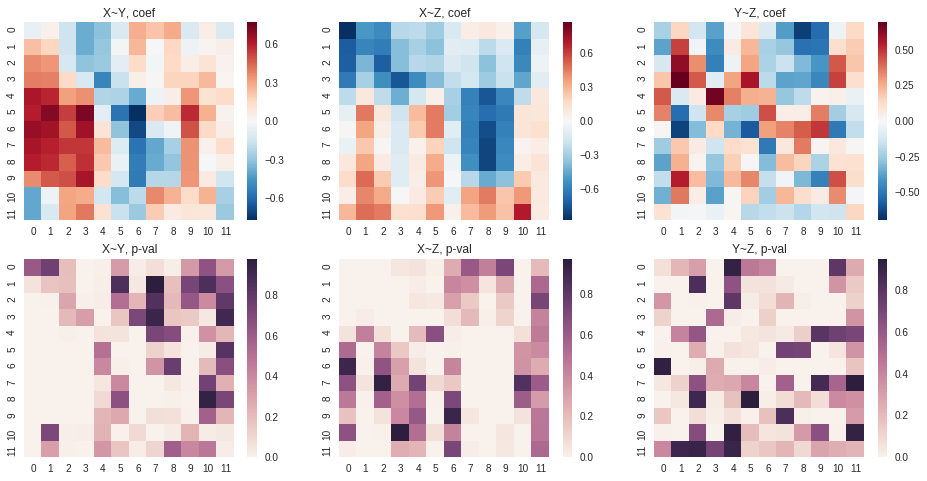

In [212]:
(c_c1, c_p1), (c_c2, c_p2), (c_c3, c_p3) = plot_heatmap(df_cdr_x, df_cdr_y, df_cdr_z, stats.pearsonr)

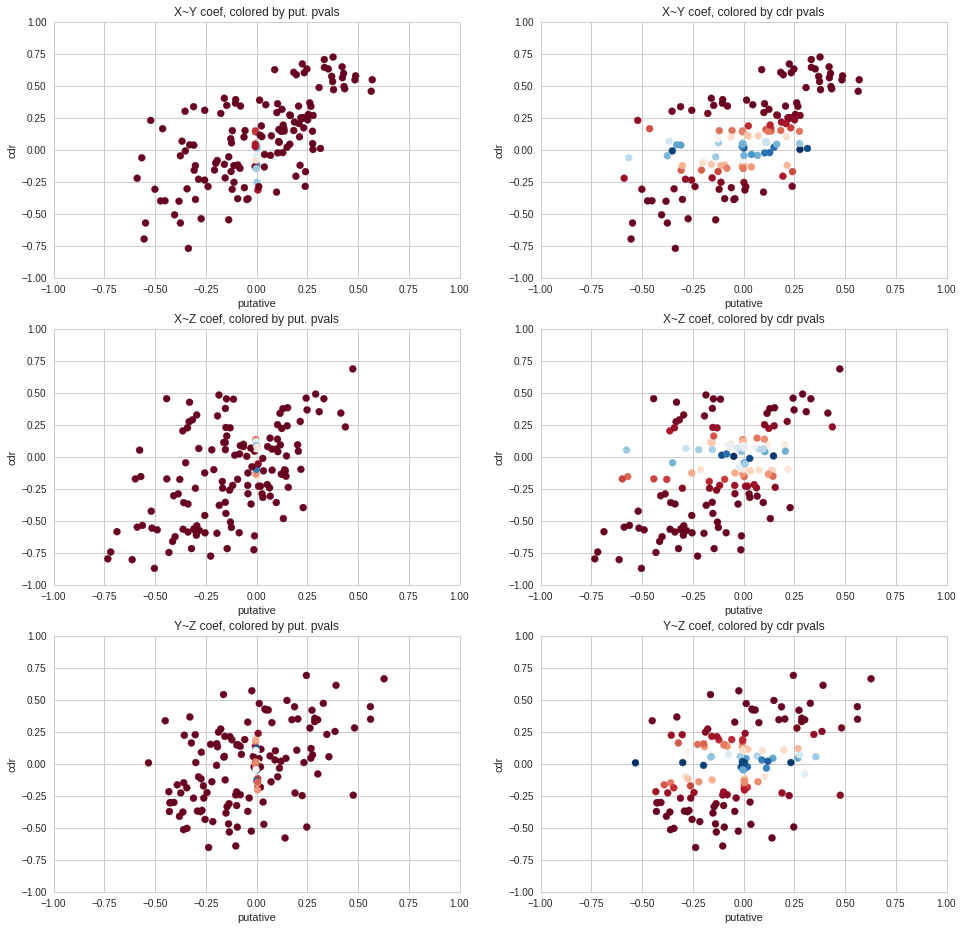

In [213]:
fig, ax = plt.subplots(3, 2, figsize=(16,16))


ax[0,0].set_xlabel('putative')
ax[0,0].set_ylabel('cdr')
ax[0,0].set_xlim([-1,1])
ax[0,0].set_ylim([-1,1])
ax[0,0].scatter(p_c1, c_c1, c = p_p1, cmap="RdBu")
ax[0,0].set_title("X~Y coef, colored by put. pvals")

ax[0,1].set_xlabel('putative')
ax[0,1].set_ylabel('cdr')
ax[0,1].set_xlim([-1,1])
ax[0,1].set_ylim([-1,1])
ax[0,1].scatter(p_c1, c_c1, c = c_p1, cmap="RdBu")
ax[0,1].set_title("X~Y coef, colored by cdr pvals")

ax[1,0].set_xlabel('putative')
ax[1,0].set_ylabel('cdr')
ax[1,0].set_xlim([-1,1])
ax[1,0].set_ylim([-1,1])
ax[1,0].scatter(p_c2, c_c2, c = p_p2, cmap="RdBu")
ax[1,0].set_title("X~Z coef, colored by put. pvals")

ax[1,1].set_xlabel('putative')
ax[1,1].set_ylabel('cdr')
ax[1,1].set_xlim([-1,1])
ax[1,1].set_ylim([-1,1])
ax[1,1].scatter(p_c2, c_c2, c = c_p2, cmap="RdBu")
ax[1,1].set_title("X~Z coef, colored by cdr pvals")

ax[2,0].set_xlabel('putative')
ax[2,0].set_ylabel('cdr')
ax[2,0].set_xlim([-1,1])
ax[2,0].set_ylim([-1,1])
ax[2,0].scatter(p_c3, c_c3, c = p_p3, cmap="RdBu")
ax[2,0].set_title("Y~Z coef, colored by put. pvals")

ax[2,1].set_xlabel('putative')
ax[2,1].set_ylabel('cdr')
ax[2,1].set_xlim([-1,1])
ax[2,1].set_ylim([-1,1])
ax[2,1].scatter(p_c3, c_c3, c = c_p3, cmap="RdBu")
ax[2,1].set_title("Y~Z coef, colored by cdr pvals")

## Summary

Many non-zero and strong correlations gives us a hope for building a model for prediction of coordinates based on two other coordinates.

Correlations are very similar for both datasets, however, more careful analysis of outliers is needed in order to make robust training test.

Strong correlations may exist due to the huge imbalance in the data, i.e., imbalance in the "upside" / "downside" peptide counts.

# Distribution of distances to the nearest putative CDR from real CDRs (by MSE)

In [216]:
df_put

,pdb_id,chain,length,pos,aa,x,y,z,rmsd
0,12ca,A_72,13,0,A,0.000000,0.000000e+00,0.000000e+00,1.471901
1,12ca,A_72,13,1,V,2.435867,4.196658e-01,2.914133e+00,1.471901
2,12ca,A_72,13,2,L,3.901272,-1.472012e+00,5.806936e+00,1.471901
3,12ca,A_72,13,3,K,5.112862,3.738015e-01,8.957265e+00,1.471901
4,12ca,A_72,13,4,G,5.346375,-9.342854e-02,1.273814e+01,1.471901
5,12ca,A_72,13,5,G,6.424403,-3.390903e+00,1.433692e+01,1.471901
6,12ca,A_72,13,6,P,10.237835,-3.868015e+00,1.414400e+01,1.471901
7,12ca,A_72,13,7,L,10.422076,-1.489832e+00,1.120009e+01,1.471901
8,12ca,A_72,13,8,D,11.773136,2.019628e+00,1.108216e+01,1.471901
9,12ca,A_72,13,9,G,10.111284,4.121258e+00,8.361834e+00,1.471901


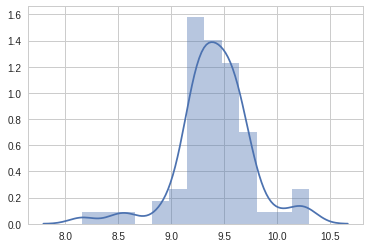

In [214]:
arr_put_coord = np.array(df_put_coord[range(1,MAX_POS+1)])
arr_cdr_coord = np.array(df_cdr_coord[range(1,MAX_POS+1)])

dist = []
for arr in arr_cdr_coord:
    dist.append(np.sqrt(((arr_put_coord - arr) ** 2).mean(1).min()))
    
sns.distplot(dist)

In [215]:
arr_can_coord = np.array(df_can_coord[range(1,MAX_POS+1)])
arr_cdr_coord = np.array(df_cdr_coord[range(1,MAX_POS+1)])

dist = []
for arr in arr_cdr_coord:
    dist.append(np.sqrt(((arr_can_coord - arr) ** 2).mean(1).min()))
    
sns.distplot(dist)

NameError: name 'df_can_coord' is not defined